# INTRODUCTION TO MACHINE LEARNING PROJECT

## Imports

In [309]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
np.random.seed(42)

# NOTES
# TODO make doxygen-like comments ?
# TODO confirm the experimental results with theoretical results
# TODO weighted knn, weighting the closest points 
# TODO calculate variance and std to know the right number of folds
# TODO do PCA function from scratch
# TODO for the best k, redo cross val to tune the best distance metric
# TODO mixing/averaging distances metrics and compare the scores
# TODO modify assert into raise ValueError for user input verif
# TODO return just the conf matrix and then implement functions that calculate the other metrics based on it
# TODO ensemble methods on imbalanced dataset. but maybe need weighted knn
# TODO start LATEX

# TODO precomputing distances considered as cheating ?


## Loading Data

In [310]:
from sklearn.decomposition import PCA

# Assuming features is a NumPy array
def plot_pca(x_train, y_train, train_point_size=10):
    # Applying PCA to reduce to 2 dimensions for visualization
    pca = PCA(n_components=2)
    x_train_pca = pca.fit_transform(x_train)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], c=y_train, cmap='viridis', marker='o', s=train_point_size)

    plt.colorbar(scatter)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

    
def load_data(dataset_file):
    return np.loadtxt(dataset_file, delimiter=',')

data = load_data('./waveform.data')

# Splitting the features and the labels into two different arrays
features = np.array(data[:,:data.shape[1]-1])

# Normalization of the features such that each feature has a mean = 0 and std = 1
def normalization(feat_to_norm) :
    new = np.empty(shape=feat_to_norm.shape)
    for i in range(feat_to_norm.shape[1]) :
        mean = np.mean(feat_to_norm[:,i])
        std = np.std(feat_to_norm[:,i])
        new[:,i] = (feat_to_norm[:,i] - mean) / std
    return new

features = normalization(feat_to_norm=features)

labels = np.array(data[:,data.shape[1]-1:])

###  Creating the dataset in python

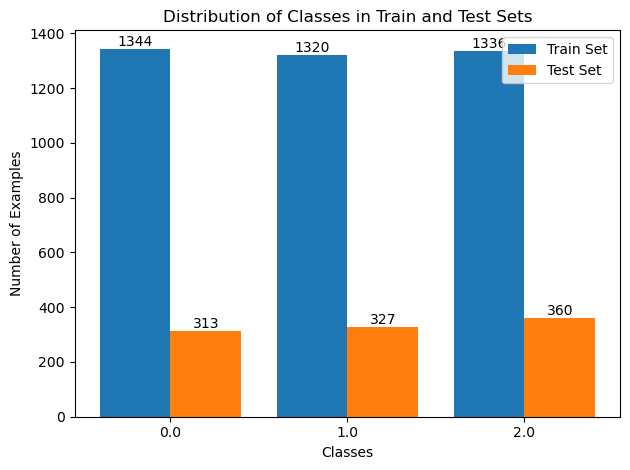

In [311]:
def train_test_split(features, labels, train_ratio):
    assert features.shape[0] == labels.shape[0], "Error : dimensions of features and labels should be the same"

    # Randomly shuffling the dataset's indices to pick randomly the training and test examples
    shuffled_indices = np.arange(features.shape[0])
    np.random.shuffle(shuffled_indices)
    train_size = int(len(shuffled_indices) * train_ratio)
    train_indices = shuffled_indices[:train_size]
    test_indices = shuffled_indices[train_size:]

    x_set = features[train_indices]
    x_test = features[test_indices]
    y_train = labels[train_indices]
    y_test = labels[test_indices]

    assert x_set.shape[0] == y_train.shape[0], "Error : creation of training set went wrong."
    assert x_test.shape[0] == y_test.shape[0], "Error : creation of testing set went wrong."

    return x_set, x_test, y_train, y_test

x_train, x_test, y_train, y_test = train_test_split(features, labels, 0.8)

#Plotting the distribution of the training and test set
train_classes, train_counts = np.unique(y_train, return_counts=True)
test_classes, test_counts = np.unique(y_test, return_counts=True)
fig, ax = plt.subplots()

# Set up positions for the bars
bar_width = 0.4
train_positions = np.arange(len(train_classes))
test_positions = train_positions + bar_width

# Plot the training and test set distributions
bar1 = ax.bar(train_positions, train_counts, bar_width, label='Train Set')
bar2 = ax.bar(test_positions, test_counts, bar_width, label='Test Set')

# Labeling the plot
ax.set_xlabel('Classes')
ax.set_ylabel('Number of Examples')
ax.set_title('Distribution of Classes in Train and Test Sets')
ax.set_xticks(train_positions + bar_width / 2)
ax.set_xticklabels(train_classes)
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f}', ha='center', va='bottom')

ax.legend()

# Display the plot
plt.tight_layout()
plt.show()


### Various functions

In [312]:
# Returns an array with the euclidian distances from x to every x' in x_array
def euclidian_dist_array(x, x_array):
    return np.linalg.norm(x_array - x, axis=1).reshape(-1, 1)

def distance_matrix(matrixA, matrixB):
    return scipy.spatial.distance_matrix(matrixA, matrixB, p=2)

def accuracy(nb_true, nb_total):
    return (nb_true * 100) / nb_total

## KNN Algorithm

In [313]:
# Returns the majority class from the features amongst the k nearest neighbors of new_input
# The distances needs to be precomputed and passed in distance_mat
# labels is composed to the corresponding labels for each value of the distance_mat
def knn(distance_tab, labels, k):
    # Getting the distances from the actual input to every other samples (in tab num_fold at index index in the list list_dist_mat which)
    assert len(labels) == len(distance_tab), "Error : number of labels and number of distances not equals"

    dist_array = distance_tab

    # Sorting the array by increasing distance order and getting the indices to get the labels
    k_nearest_indices = np.argpartition(dist_array, k)[:k]

    # Get the labels of the k nearest neighbors
    classes = labels[k_nearest_indices].ravel()

    # Count the number of occurences of each class Yj among the k nearest neighbors
    counts = np.bincount(classes[:k].astype(int))

    # Return the class with the highest count
    majority_class = np.argmax(counts)

    return majority_class



### Metrics calculation : accuracy, confusion matrix, etc...

In [314]:
# Returns the accuracy, confusion matrix of the prediction of the test set amongst the train set
# distance_mat : precomputed distances between train set and test set
def prediction_metrics(distance_mat, y_set_train, y_set_test, k):
    right_predictions = 0
    len_y_set_test = len(y_set_test)

    classes = np.unique(y_set_test)
    nb_classes = len(classes)
    confusion_matrix = np.zeros((nb_classes, nb_classes))

    # Predict the class for each point of the set test amongst the set train
    # Distances are precomputed in the distance matrix
    for i in range(len_y_set_test) :
        y_pred = knn(distance_mat[i], y_set_train, k)
        y_actual = y_set_test[i, 0]

        if (y_pred == y_actual):
            right_predictions +=1

        index_pred = np.where(classes == y_pred)[0][0]
        index_actual = np.where(classes == y_actual)[0][0]
        confusion_matrix[index_actual, index_pred] += 1

    accuracy = (right_predictions * 100) / len_y_set_test
    return accuracy, confusion_matrix


## Tuning k by cross-validation

### Creating the k folds

In [315]:
# Splitting the training set into x_subsets for cross-validation
def k_folds(x_training_set, y_training_set, nb_folds):
    if nb_folds > x_training_set.shape[0]:
        raise ValueError("Error : number of folds exceeding the number of samples in the dataset.")
    # Shuffling the sets to get random folds
    indices = np.arange(x_training_set.shape[0])
    np.random.shuffle(indices)
    x_shuffled = x_training_set[indices]
    y_shuffled = y_training_set[indices]
    
    # Split the shuffled data into folds
    x = np.array_split(x_shuffled, nb_folds)
    y = np.array_split(y_shuffled, nb_folds)

    assert len(x) == len(y), "Error creating the subsets for cross-validation"
    return x, y

nb_folds = 5
x_subsets, y_subsets = k_folds(x_train, y_train, nb_folds)


### Pre-computing the distances of the k folds between them

In [316]:
# Returns a list of distances matrix of each fold of x_folds against the remaining folds
def list_distance_matrix(nb_folds, x_folds):
    # Precompute the distances between each fold and the k-1 other folds to accelerate computation
    list_dist_mat = []
    for i in range(nb_folds) : 
        x_tmp_training = np.concatenate([x_folds[j] for j in range(nb_folds) if j != i], axis=0)
        x_val_fold = x_folds[i]
        dist_mat = distance_matrix(x_val_fold, x_tmp_training)
        list_dist_mat.append(dist_mat)
    return list_dist_mat

list_dist_mat = list_distance_matrix(nb_folds=nb_folds, x_folds=x_subsets)
print("Number of distance matrices : "+str(len(list_dist_mat)))


Number of distance matrices : 5


### Cross-validation algorithm

In [317]:
# Returns the metrics for a given k using cross-validation
def cross_validation(k, x_train_folds, y_train_folds, nb_folds, list_dist_mat):
    fold_accuracies = []
    fold_confusion_matrices = []

    # Computing the metrics for each fold taken once(as a validation fold) over the k-1 training folds
    for i in range(nb_folds):
        # Remove the validation set from the training set
        x_tmp_training = np.concatenate([x_train_folds[j] for j in range(nb_folds) if j != i], axis=0)
        y_tmp_training = np.concatenate([y_train_folds[j] for j in range(nb_folds) if j != i], axis=0)

        # Take the remaining fold as the validation fold
        x_val_fold = x_train_folds[i]
        y_val_fold = y_train_folds[i]
        
        fold_accuracy, fold_cm = (prediction_metrics(distance_mat=list_dist_mat[i],
                                                     y_set_train=y_tmp_training, 
                                                     y_set_test=y_val_fold, 
                                                     k=k))
        fold_accuracies.append(fold_accuracy)
        fold_confusion_matrices.append(fold_cm)

    print("Validation folds accuracies :"+str(fold_accuracies))
    
    # Returning the mean of the metrics
    mean_accuracy = np.mean(fold_accuracies)
    mean_confusion_matrix = np.mean(fold_confusion_matrices, axis=0)
    return mean_accuracy, mean_confusion_matrix

### Finding the best k using cross-validation

In [318]:
# Returns the best k using cross-validation
def tuning_k(nb_folds, x_folds, y_folds, k_range, list_dist_mat):
    list_accuracies = []
    list_confusion_matrices = []

    # Iterate over the whole k range
    for k in k_range : 
        print("k = "+str(k))
        # Get the mean metrics for this k over the entire folds using cross-validation
        mean_acc, mean_cm = cross_validation(k, x_folds, y_folds, nb_folds, list_dist_mat)
        list_accuracies.append(mean_acc)  
        list_confusion_matrices.append(mean_cm)
        print("Mean accuracy = "+str(mean_acc))
        print("Confusion Matrix : \n"+str(mean_cm))

    max_accuracy = max(list_accuracies)
    best_k = k_range[list_accuracies.index(max_accuracy)] 

    # Returning the best k found, the mean accuracies for each k over the folds, and the mean CM for each k
    return best_k, list_accuracies, list_confusion_matrices

k_max = int(x_train.shape[0] - (x_train.shape[0] / nb_folds))
k_range = range(1, 100)

best_k, accuracies, confusion_matrices = tuning_k(nb_folds=nb_folds, x_folds=x_subsets, y_folds=y_subsets, k_range=k_range, list_dist_mat=list_dist_mat)
max_accuracy = max(accuracies)


k = 1
Validation folds accuracies :[76.625, 76.75, 77.5, 74.875, 75.375]
Mean accuracy = 76.225
Confusion Matrix : 
[[192.6  38.6  37.6]
 [ 31.8 209.6  22.6]
 [ 34.   25.6 207.6]]
k = 2
Validation folds accuracies :[75.125, 77.0, 76.75, 74.25, 74.5]
Mean accuracy = 75.525
Confusion Matrix : 
[[231.2  18.   19.6]
 [ 54.6 201.    8.4]
 [ 55.2  40.  172. ]]
k = 3
Validation folds accuracies :[80.5, 80.625, 81.75, 79.875, 78.875]
Mean accuracy = 80.325
Confusion Matrix : 
[[199.   35.2  34.6]
 [ 26.2 219.8  18. ]
 [ 23.8  19.6 223.8]]
k = 4
Validation folds accuracies :[80.5, 80.25, 82.125, 80.125, 78.625]
Mean accuracy = 80.325
Confusion Matrix : 
[[225.8  21.8  21.2]
 [ 38.6 214.4  11. ]
 [ 34.8  30.  202.4]]
k = 5
Validation folds accuracies :[81.0, 81.75, 82.875, 82.25, 81.375]
Mean accuracy = 81.85
Confusion Matrix : 
[[201.2  33.8  33.8]
 [ 23.4 224.2  16.4]
 [ 20.   17.8 229.4]]
k = 6
Validation folds accuracies :[81.125, 81.375, 82.875, 82.25, 79.75]
Mean accuracy = 81.475
Confusio

### Plotting of the accuracies with respect to k

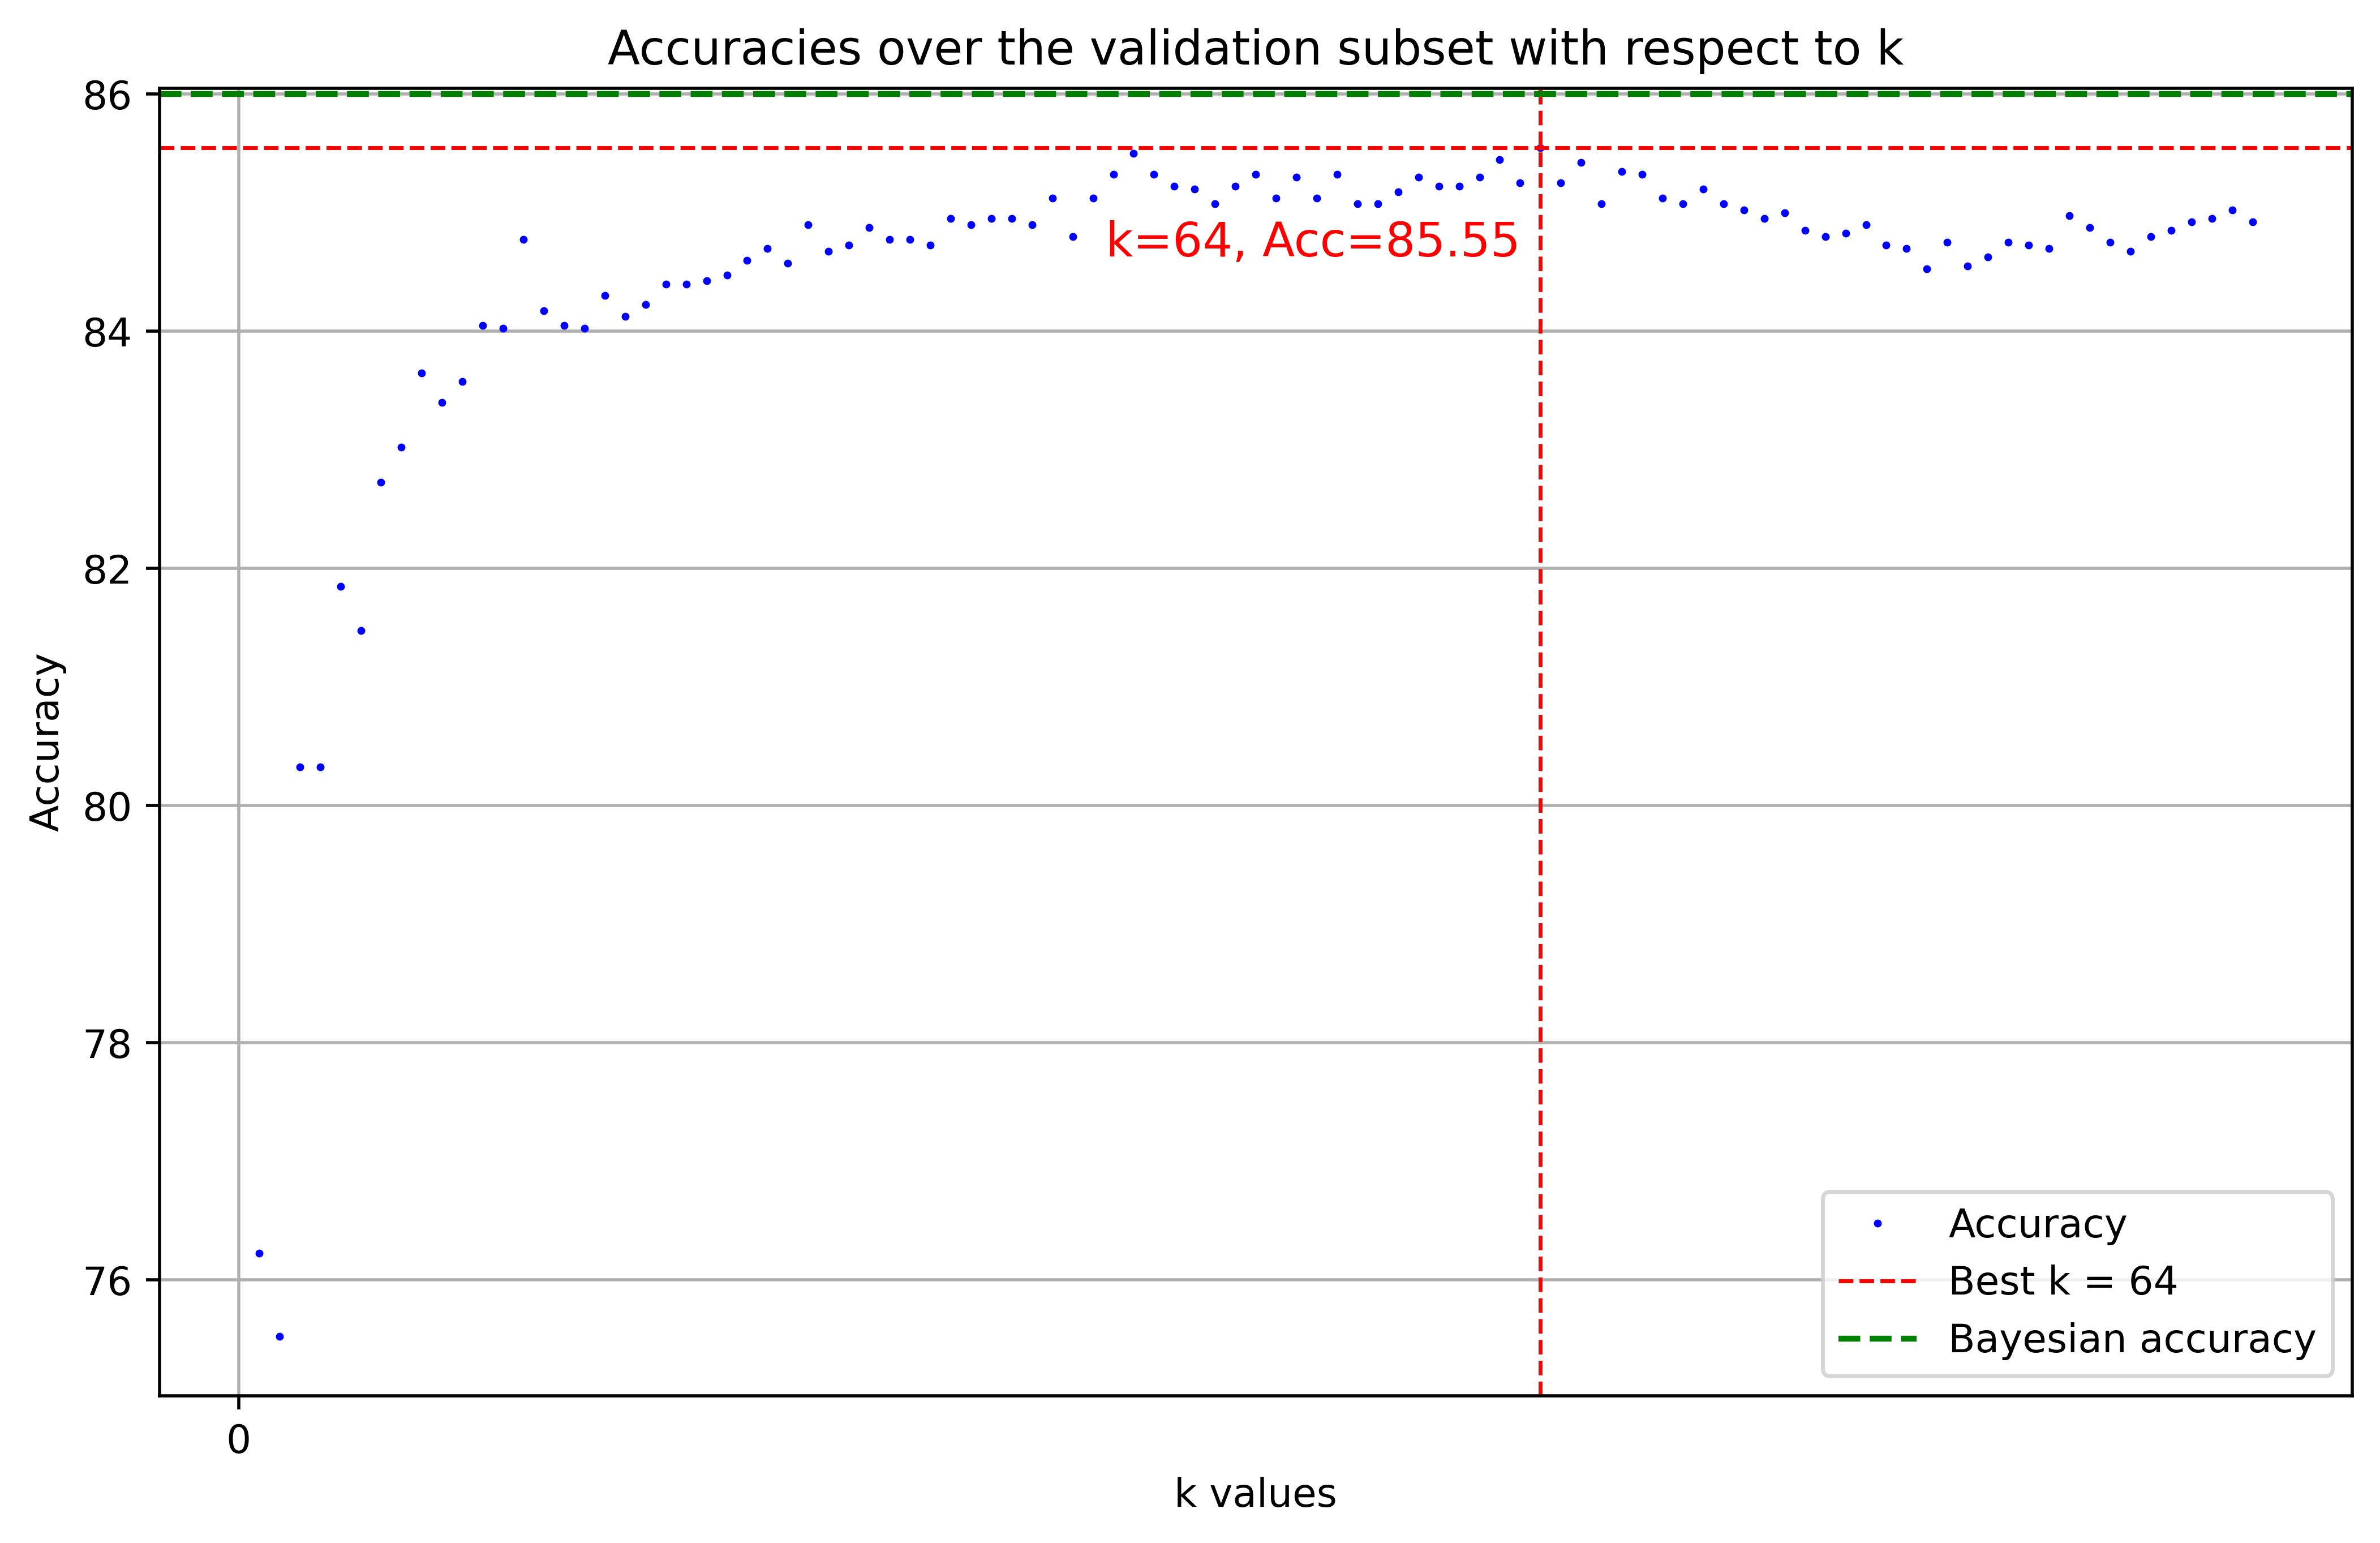

In [319]:
plt.figure(figsize=(10, 6), dpi=500) 
plt.plot(k_range, accuracies, label='Accuracy', marker='o', color='b',markersize=1,linestyle='None')
plt.axvline(x=best_k, color='r', linestyle='--', linewidth=1, label=f'Best k = {best_k}')
plt.axhline(y=max_accuracy, color='r', linestyle='--', linewidth=1)
plt.axhline(y=86, color='g', linestyle='--', label=f'Bayesian accuracy')
plt.text(best_k-1, max_accuracy-1, f'k={best_k}, Acc={max_accuracy:.2f}', 
         horizontalalignment='right', verticalalignment='bottom', 
         color='red', fontsize=12)
plt.xlabel('k values')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0, max(k_range)+2, 200)) 
plt.grid(True)
plt.legend()
plt.title("Accuracies over the validation subset with respect to k")
plt.show()


### Confusion matrix of the best k

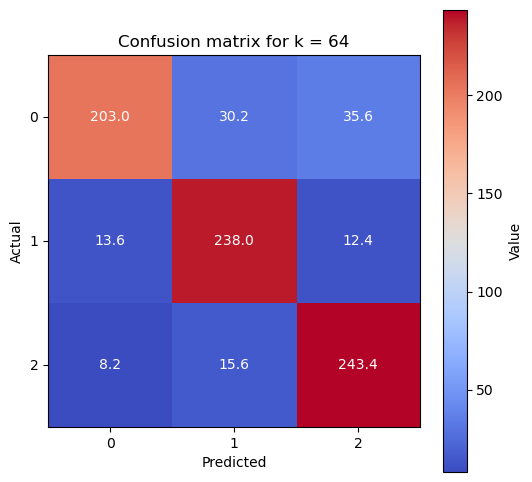

In [320]:
def plot_confusion_matrix(matrix, title):
    plt.figure(figsize=(6, 6))
    plt.imshow(matrix, cmap='coolwarm')
    plt.colorbar(label='Value')
    for (i, j), value in np.ndenumerate(matrix):
        plt.text(j, i, f'{value}', ha='center', va='center', color='white')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.xticks(np.arange(matrix.shape[1]), ['0', '1', '2'])
    plt.yticks(np.arange(matrix.shape[0]), ['0', '1', '2'])
    plt.show()

confusion_mat_best_k = confusion_matrices[accuracies.index(max_accuracy)]
plot_confusion_matrix(confusion_mat_best_k,"Confusion matrix for k = "+str(best_k))

### Prediction on the test set using the best k found

Accuracy : 86.0


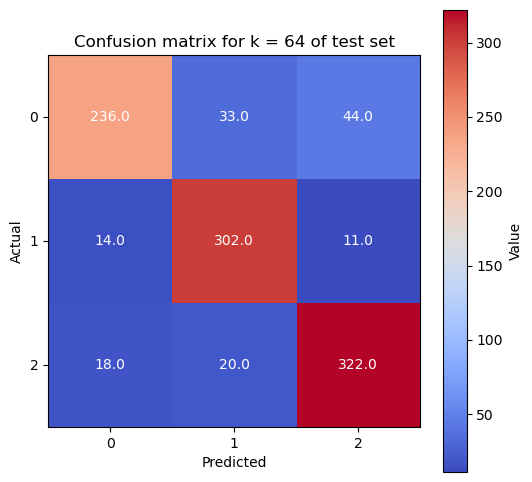

In [322]:
#Pre-compute the distances between the test set and the training set
dist_test = distance_matrix(x_test, x_train)
test_acc, test_cm = prediction_metrics(distance_mat=dist_test, y_set_train=y_train, y_set_test=y_test, k=best_k)
print("Accuracy : "+str(test_acc))
plot_confusion_matrix(test_cm,"Confusion matrix for k = "+str(best_k)+" of test set")


# TEST

In [324]:
import numpy as np
from sklearn.model_selection import PredefinedSplit, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
scikit_x_train = x_train.copy()
scikit_y_train = y_train.copy()
scikit_x_test = x_test.copy()
scikit_y_test = y_test.copy()
scikit_k_range = k_range
scikit_x_subsets = x_subsets.copy()
scikit_y_subsets = y_subsets.copy()


In [325]:
# Combine all folds into one array
scikit_x_combined = np.concatenate(scikit_x_subsets, axis=0)
scikit_y_combined = np.concatenate(scikit_y_subsets, axis=0)

# Create an array of indices where each index corresponds to the fold number
scikit_fold_indices = []
for i, scikit_subset in enumerate(scikit_x_subsets):
    scikit_fold_indices.extend([i] * len(scikit_subset))
scikit_fold_indices = np.array(scikit_fold_indices)

# Define PredefinedSplit with your fold indices
scikit_ps = PredefinedSplit(scikit_fold_indices)

scikit_mean_accuracies = []

# Perform cross-validation for each k using your predefined folds
for scikit_k in scikit_k_range:
    scikit_knn = KNeighborsClassifier(n_neighbors=scikit_k)
    scikit_scores = cross_val_score(scikit_knn, scikit_x_combined, scikit_y_combined.ravel(), cv=scikit_ps, scoring='accuracy')
    scikit_mean_accuracies.append(scikit_scores.mean())  # Average accuracy for this k


Best k: 64, Mean Accuracy: 0.8555
Test Set Accuracy with Best k: 0.8600


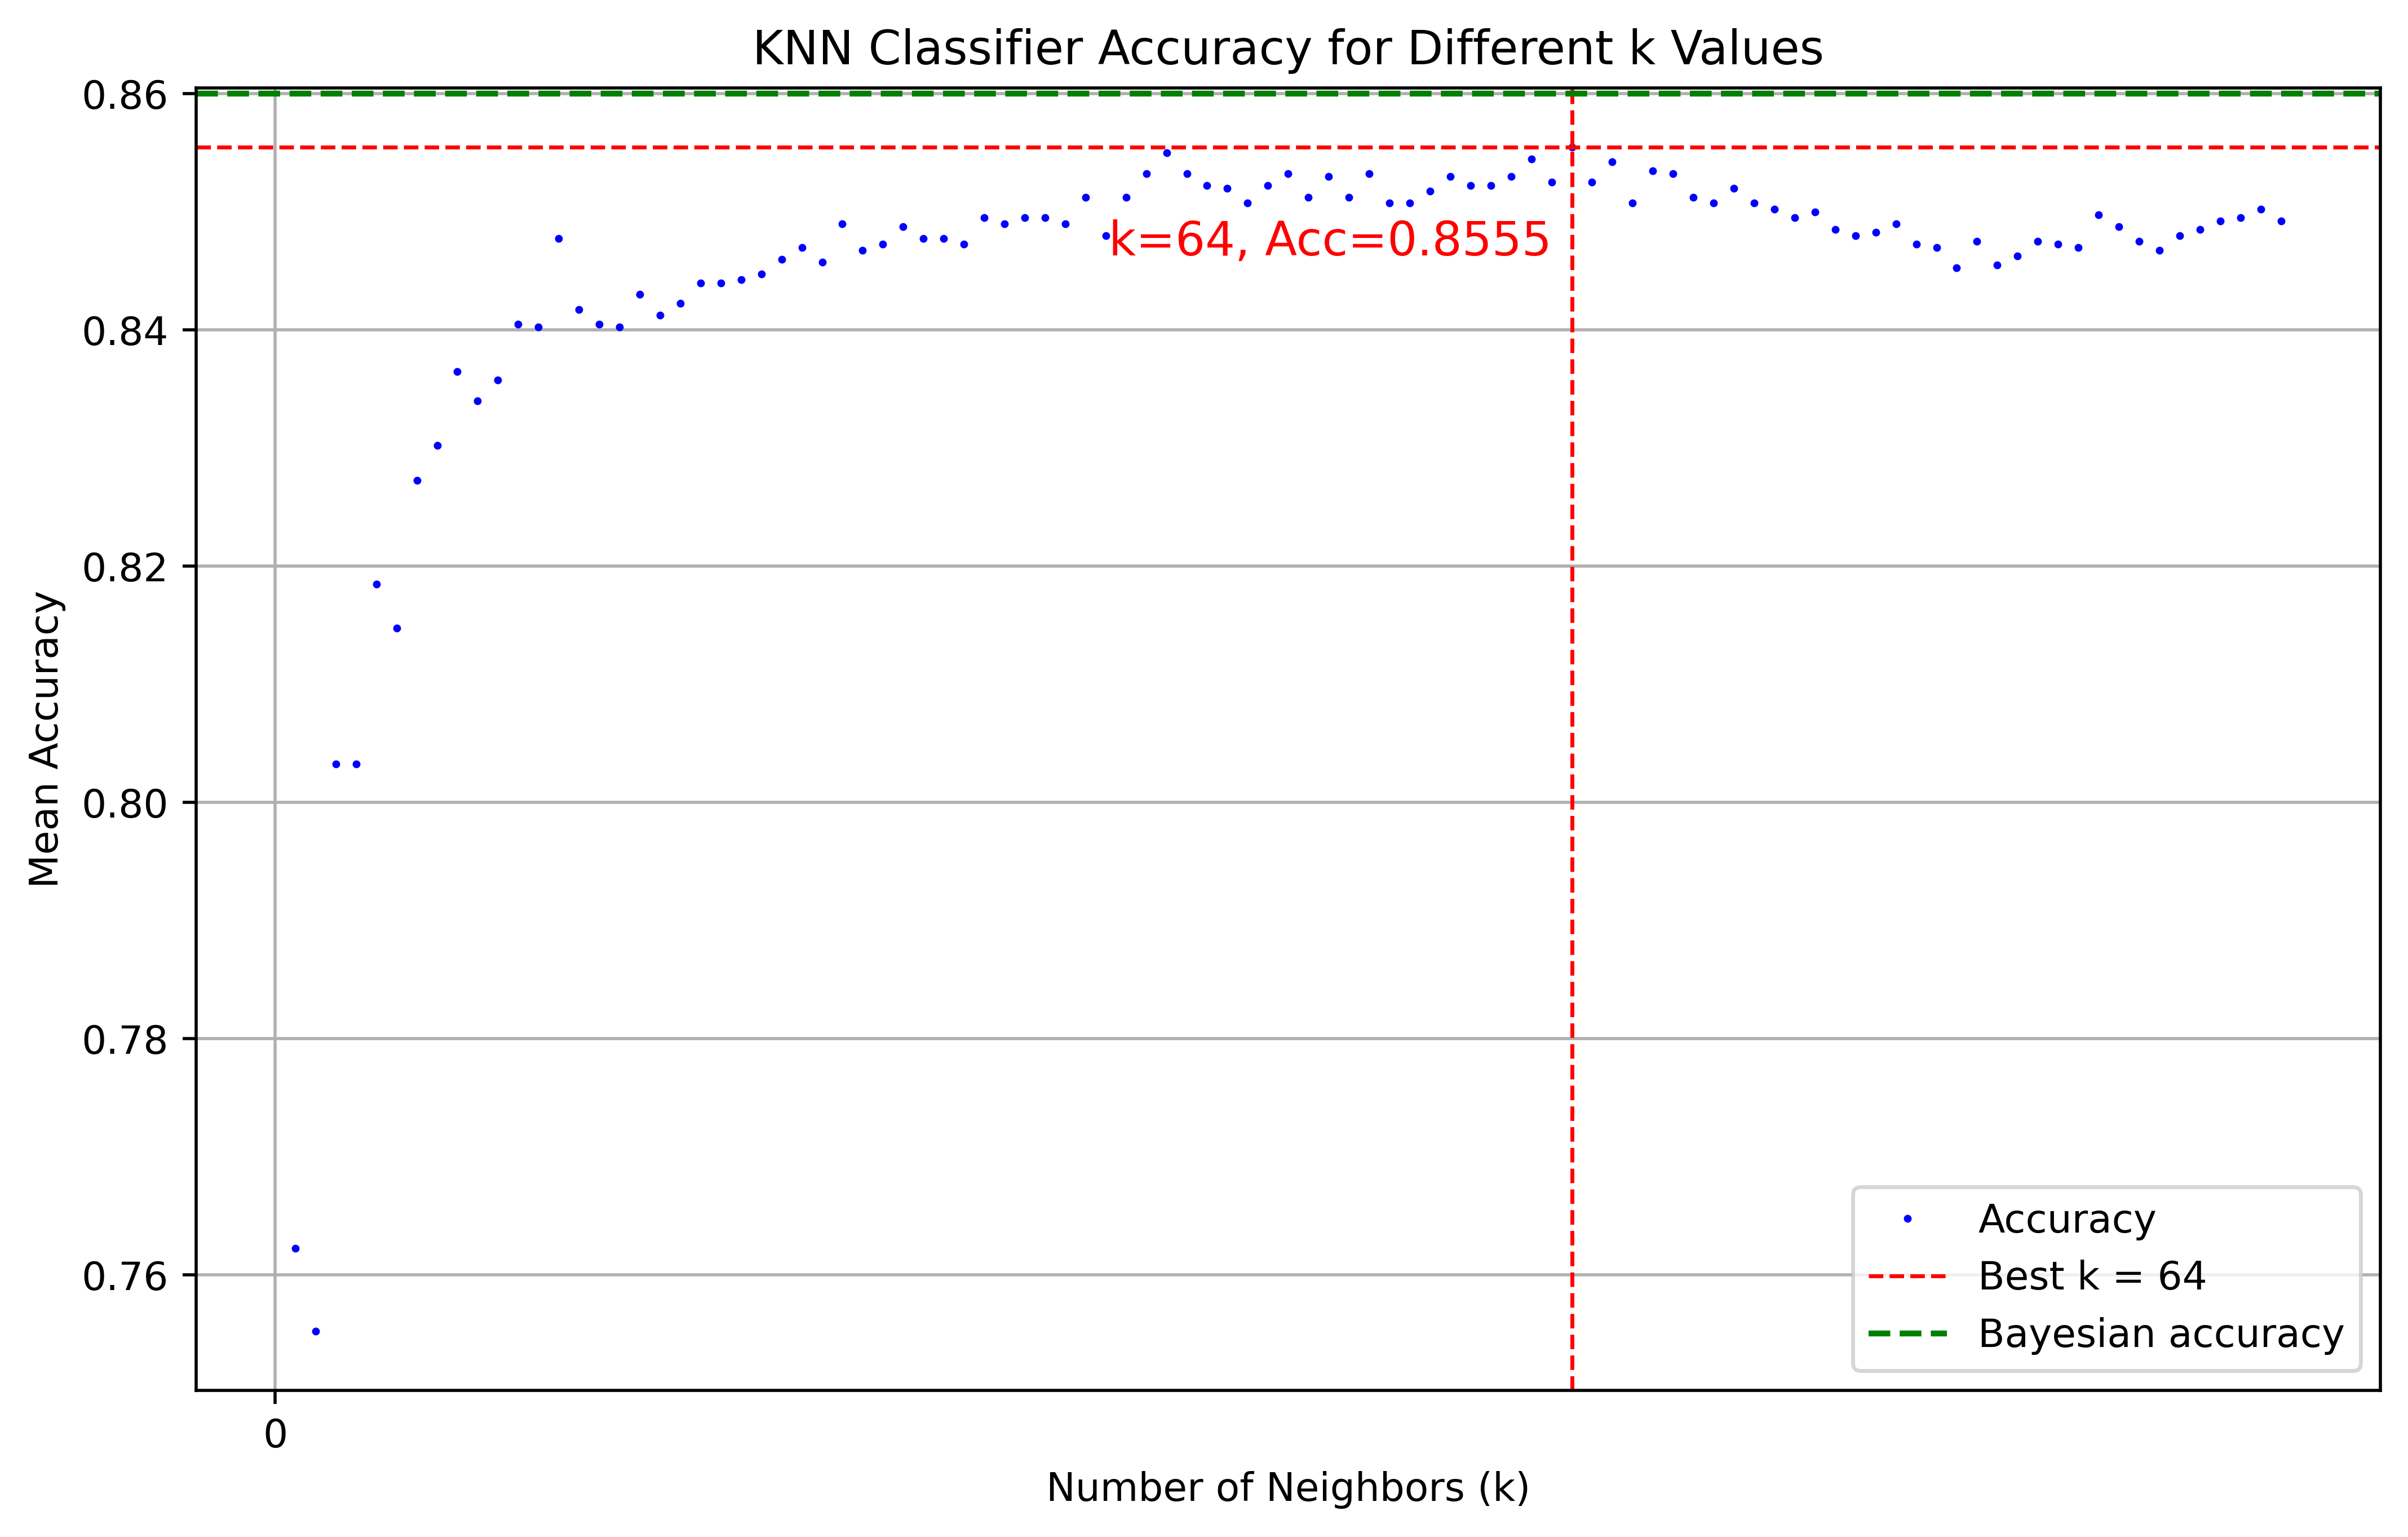

In [326]:
scikit_best_k = scikit_k_range[np.argmax(scikit_mean_accuracies)]
print(f'Best k: {scikit_best_k}, Mean Accuracy: {max(scikit_mean_accuracies):.4f}')

scikit_knn_best = KNeighborsClassifier(n_neighbors=scikit_best_k)
scikit_knn_best.fit(scikit_x_train, scikit_y_train.ravel())  # Fit on the entire training set
scikit_test_acc = scikit_knn_best.score(scikit_x_test, scikit_y_test)  # Evaluate on the test set
print(f'Test Set Accuracy with Best k: {scikit_test_acc:.4f}')

### Plotting Accuracies
plt.figure(figsize=(10, 6), dpi=500)
plt.plot(scikit_k_range, scikit_mean_accuracies, label='Accuracy', marker='o', color='b', markersize=1, linestyle='None')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Accuracy')
plt.title('KNN Classifier Accuracy for Different k Values')
plt.xticks(np.arange(0, max(scikit_k_range) + 1, 100))
scikit_max_accuracy = max(scikit_mean_accuracies)
scikit_best_k = scikit_k_range[np.argmax(scikit_mean_accuracies)]
plt.axvline(x=scikit_best_k, color='r', linestyle='--', linewidth=1, label=f'Best k = {scikit_best_k}')
plt.axhline(y=scikit_max_accuracy, color='r', linestyle='--', linewidth=1)
plt.axhline(y=.86, color='g', linestyle='--', label=f'Bayesian accuracy')
plt.text(scikit_best_k - 1, scikit_max_accuracy-.01, f'k={scikit_best_k}, Acc={scikit_max_accuracy:.4f}', 
         horizontalalignment='right', verticalalignment='bottom', 
         color='red', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()


# Reducing complexity